<a href="https://colab.research.google.com/github/devdogukan/turkish-sentiment-analysis/blob/main/turkish-sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import copy

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 15
PATIENCE = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
label2id = {"Negative": 0, "Notr": 1, "Positive": 2}
id2label = {v: k for k, v in label2id.items()}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/tsa-winvoker/dataset/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/tsa-winvoker/dataset/test.csv")

train_df["label"] = train_df["label"].map(label2id)
test_df["label"] = test_df["label"].map(label2id)

In [ ]:
class BertTokenizedDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = BertTokenizedDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
test_dataset = BertTokenizedDataset(test_df["text"].tolist(), test_df["label"].tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        _, h = self.gru(x)
        h = torch.cat((h[-2], h[-1]), dim=1)
        h = self.dropout(h)
        return self.fc(h)

In [ ]:
model = GRUClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=128,
    hidden_dim=128,
    output_dim=3,
    pad_idx=tokenizer.pad_token_id
).to(DEVICE)

class_counts = train_df["label"].value_counts().sort_index()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
def train_with_metrics_and_early_stopping(model, train_loader, val_loader, optimizer, criterion, device, epochs=5, patience=2):
    best_f1 = 0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"\n🎯 Epoch {epoch+1} - Train Loss: {total_loss:.4f}")

        # Evaluation
        model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"]
                outputs = model(input_ids)
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average="weighted")
        precision = precision_score(all_labels, all_preds, average="weighted")
        recall = recall_score(all_labels, all_preds, average="weighted")

        print(f"🧪 Val Acc: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print("✅ Yeni en iyi model kaydedildi.")
        else:
            patience_counter += 1
            print(f"⚠️ Gelişme yok ({patience_counter}/{patience})")
            if patience_counter >= patience:
                print("⏹️ Early stopping: F1 daha fazla artmadı.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("📦 En iyi model geri yüklendi (F1 = {:.4f})".format(best_f1))

    return model

In [ ]:
model = train_with_metrics_and_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=EPOCHS,
    patience=PATIENCE
)

Epoch 1/15: 100%|██████████| 6886/6886 [02:43<00:00, 42.05it/s]



🎯 Epoch 1 - Train Loss: 1661.6347
🧪 Val Acc: 0.9346, F1: 0.9375, Precision: 0.9445, Recall: 0.9346
✅ Yeni en iyi model kaydedildi.


Epoch 2/15: 100%|██████████| 6886/6886 [02:43<00:00, 42.22it/s]



🎯 Epoch 2 - Train Loss: 1048.7041
🧪 Val Acc: 0.9349, F1: 0.9380, Precision: 0.9460, Recall: 0.9349
✅ Yeni en iyi model kaydedildi.


Epoch 3/15: 100%|██████████| 6886/6886 [02:43<00:00, 42.20it/s]



🎯 Epoch 3 - Train Loss: 818.0316
🧪 Val Acc: 0.9412, F1: 0.9436, Precision: 0.9492, Recall: 0.9412
✅ Yeni en iyi model kaydedildi.


Epoch 4/15: 100%|██████████| 6886/6886 [02:43<00:00, 42.15it/s]



🎯 Epoch 4 - Train Loss: 623.2819
🧪 Val Acc: 0.9476, F1: 0.9489, Precision: 0.9514, Recall: 0.9476
✅ Yeni en iyi model kaydedildi.


Epoch 5/15: 100%|██████████| 6886/6886 [02:44<00:00, 41.84it/s]



🎯 Epoch 5 - Train Loss: 486.4267
🧪 Val Acc: 0.9382, F1: 0.9408, Precision: 0.9468, Recall: 0.9382
⚠️ Gelişme yok (1/2)


Epoch 6/15: 100%|██████████| 6886/6886 [02:45<00:00, 41.70it/s]



🎯 Epoch 6 - Train Loss: 393.9391
🧪 Val Acc: 0.9477, F1: 0.9486, Precision: 0.9501, Recall: 0.9477
⚠️ Gelişme yok (2/2)
⏹️ Early stopping: F1 daha fazla artmadı.
📦 En iyi model geri yüklendi (F1 = 0.9489)


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["labels"]
        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

In [ ]:
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label2id.keys())))

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.86      0.80      5656
        Notr       0.99      0.99      0.99     17092
    Positive       0.97      0.94      0.95     26217

    accuracy                           0.95     48965
   macro avg       0.90      0.93      0.92     48965
weighted avg       0.95      0.95      0.95     48965



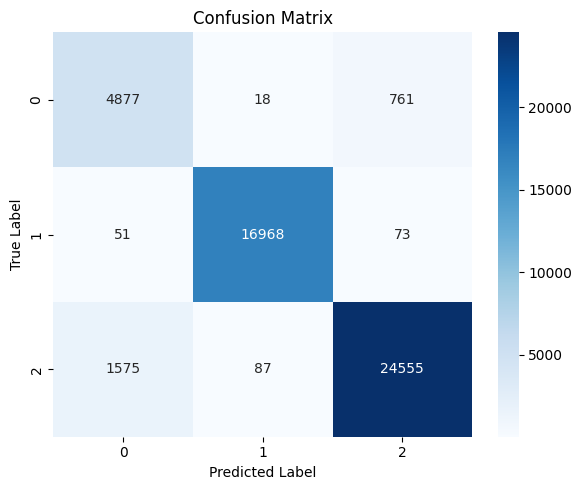

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix hesapla
cm = confusion_matrix(all_labels, all_preds)

# Görselleştir
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label, yticklabels=id2label)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/tsa-winvoker/gru-tsa/gru_berturk_sentiment_model.pt")
tokenizer.save_pretrained("/content/drive/MyDrive/tsa-winvoker/gru-tsa/berturk_tokenizer")

('/content/drive/MyDrive/tsa-winvoker/gru-tsa/berturk_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/tsa-winvoker/gru-tsa/berturk_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/tsa-winvoker/gru-tsa/berturk_tokenizer/vocab.txt',
 '/content/drive/MyDrive/tsa-winvoker/gru-tsa/berturk_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/tsa-winvoker/gru-tsa/berturk_tokenizer/tokenizer.json')

In [ ]:
# Tokenizer ve model objesini tekrar oluştur
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/tsa-winvoker/gru-tsa/berturk_tokenizer")
model = GRUClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=128,
    hidden_dim=128,
    output_dim=3,
    pad_idx=tokenizer.pad_token_id
).to(DEVICE)

# Eğitilmiş ağırlıkları yükle
model.load_state_dict(torch.load("/content/drive/MyDrive/tsa-winvoker/gru-tsa/gru_berturk_sentiment_model.pt", map_location=DEVICE))
model.eval()

GRUClassifier(
  (embedding): Embedding(32000, 128, padding_idx=0)
  (gru): GRU(128, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
def predict(texts, model, tokenizer, max_len=128):
    if isinstance(texts, str):
        texts = [texts]

    model.eval()
    results = []

    with torch.no_grad():
        for text in texts:
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_len,
                return_tensors="pt"
            )
            input_ids = encoded["input_ids"].to(DEVICE)
            outputs = model(input_ids)
            pred = torch.argmax(outputs, dim=1).item()
            results.append(id2label[pred])

    return results if len(results) > 1 else results[0]

In [ ]:
print(predict(["urun cok guzel,malzeme kalitesi cok iyi. tavsiye ederim."], model, tokenizer)) # Positive
print(predict(["Bu mecazi kullanımı Türkiyeye Fransızcadan gelmiştir."], model, tokenizer)) # Notr
print(predict(["Türk filmlerini bekliyordum bu yıl sonu ama çok pişman oldum neşeli hayattan sonraki en berbat film belki de en berbatı."], model, tokenizer)) # Negative

Positive
Notr
Negative
